## Ocean Stats

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, yaml, os
from datetime import datetime
import getpass
import xarray as xr
from mom6_tools.stats import extract_time_series
warnings.filterwarnings("ignore")
from mom6_tools.DiagsCase import DiagsCase

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams.update({'font.size': 18})

In [4]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)
dcase = DiagsCase(diag_config_yml['Case'])

In [5]:
CASEROOT = dcase.get_value('CASEROOT')

In [6]:
rundir = dcase.get_value('RUNDIR')

In [7]:
DOUT_S = dcase.get_value('DOUT_S')

In [8]:
if DOUT_S:
  OUTDIR = dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = dcase.get_value('RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', dcase.casename)

Output directory is: /glade/scratch/gmarques/archive/g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001/ocn/hist/
Casename is: g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001


In [9]:
# create an empty class object
class args:
  pass

args.nw = 6 # requesting 6 workers
native = dcase.casename+diag_config_yml['Fnames']['native']
variables = ['thetaoga','soga']
extract_time_series(native, variables, dcase, args, OUTDIR)

Reading dataset...
Time elasped:  0:01:25.486353
Releasing workers...



In [10]:
header = ["Step", "Day","Truncs", "Energy/Mass",      
          "Maximum CFL", "Mean Sea Level", 
          "Total Mass", "Mean Salin", "Mean Temp",
         "Frac Mass Err", "Salin Err", "Temp Err"]
df = pd.read_csv(rundir+'/ocean.stats',  delimiter=',', 
                 usecols=(0,1,2,3,4,5,6,7,8,9,10,11),skiprows=(0,1),
                 names=header)#, skiprows=1) #, 
                # index_col=0,
                # dtype='unicode',
                # encoding = 'unicode_escape')

In [11]:
df.head()

,Step,Day,Truncs,Energy/Mass,Maximum CFL,Mean Sea Level,Total Mass,Mean Salin,Mean Temp,Frac Mass Err,Salin Err,Temp Err
0,0,0.0,0,En 4.4752190124940780E-24,CFL 0.00000,SL -5.7543E-11,M 1.38384E+21,S 34.7203,T 3.6043,Me 0.00E+00,Se 0.00E+00,Te 0.00E+00
1,23,1.0,0,En 1.0009071723262202E-03,CFL 0.10990,SL -5.6126E-11,M 1.38384E+21,S 34.7203,T 3.6042,Me -3.27E-19,Se 2.46E-16,Te 3.74E-18
2,47,2.0,0,En 1.0846203487096882E-03,CFL 0.08766,SL -5.5415E-11,M 1.38384E+21,S 34.7203,T 3.6042,Me 1.41E-19,Se 1.55E-17,Te -8.74E-19
3,71,3.0,0,En 1.1443698108270194E-03,CFL 0.09359,SL -5.4706E-11,M 1.38384E+21,S 34.7203,T 3.6042,Me 6.46E-19,Se 5.60E-17,Te -4.75E-18
4,95,4.0,0,En 1.1337063737048010E-03,CFL 0.07251,SL -5.4706E-11,M 1.38384E+21,S 34.7203,T 3.6041,Me 9.35E-20,Se -3.22E-17,Te 7.94E-18


In [12]:
# remove characters from each coloumn
for var in header[3::]:
    print(var)
    df[var] = df[var].str.replace(r'[^0-9.]+', '').astype(float)

df.head()

Energy/Mass
Maximum CFL
Mean Sea Level
Total Mass
Mean Salin
Mean Temp
Frac Mass Err
Salin Err
Temp Err


,Step,Day,Truncs,Energy/Mass,Maximum CFL,Mean Sea Level,Total Mass,Mean Salin,Mean Temp,Frac Mass Err,Salin Err,Temp Err
0,0,0.0,0,4.475219,0.00000,5.754311,1.383842,34.7203,3.6043,0.0000,0.0000,0.0000
1,23,1.0,0,1.000907,0.10990,5.612611,1.383842,34.7203,3.6042,3.2719,2.4616,3.7418
2,47,2.0,0,1.084620,0.08766,5.541511,1.383842,34.7203,3.6042,1.4119,1.5517,8.7419
3,71,3.0,0,1.144370,0.09359,5.470611,1.383842,34.7203,3.6042,6.4619,5.6017,4.7518
4,95,4.0,0,1.133706,0.07251,5.470611,1.383842,34.7203,3.6041,9.3520,3.2217,7.9418


In [13]:
# rename columns
new_header = ["Step", "Day","Truncs", "EnergyMass",      
          "MaximumCFL", "MeanSeaLevel", 
          "TotalMass", "MeanSalin", "MeanTemp",
         "FracMassErr", "SalinErr", "TempErr"]
for old, new in zip(header, new_header):
  df = df.rename(columns={old:new})

In [14]:
df.head()

,Step,Day,Truncs,EnergyMass,MaximumCFL,MeanSeaLevel,TotalMass,MeanSalin,MeanTemp,FracMassErr,SalinErr,TempErr
0,0,0.0,0,4.475219,0.00000,5.754311,1.383842,34.7203,3.6043,0.0000,0.0000,0.0000
1,23,1.0,0,1.000907,0.10990,5.612611,1.383842,34.7203,3.6042,3.2719,2.4616,3.7418
2,47,2.0,0,1.084620,0.08766,5.541511,1.383842,34.7203,3.6042,1.4119,1.5517,8.7419
3,71,3.0,0,1.144370,0.09359,5.470611,1.383842,34.7203,3.6042,6.4619,5.6017,4.7518
4,95,4.0,0,1.133706,0.07251,5.470611,1.383842,34.7203,3.6041,9.3520,3.2217,7.9418


In [15]:
units = ['nondim', 'days', 'nondim', 'm2 s-2',' nondim',
         'm', 'kg', 'PSU' , 'degC', 'nondim', 'PSU', 'degC']

data_vars = {}
for var, unit in zip(new_header, units):
  data_vars.update({var:(('time'), df[var], {"units" : unit})})

In [16]:
ds = xr.open_dataset(rundir+"/ocean.stats.nc",use_cftime=False).rename({"Time" : "time"})

In [17]:
variables = [
    'En',
    'Ntrunc',
    'Mass',
    'Mass_chg',
    'Mass_anom',
    'max_CFL_trans',
    'max_CFL_lin',
    'Salt',
    'Salt_chg',
    'Salt_anom',    
    'Heat',
    'Heat_chg',
    'Heat_anom',
    'age'
    
]

for v in variables:
  data_vars.update({v:(('time'), ds[v].values, {"units" : ds[v].units})})

In [18]:
data_vars.update({"APE":(("time", "Interface"), 
                         ds.APE.values, {"units" : ds.APE.units})})
data_vars.update({"H0":(("time", "Interface"), 
                        ds.H0.values, {"units" : ds.H0.units})})
data_vars.update({"KE":(("time", "Layer"), 
                        ds.KE.values, {"units" : ds.KE.units})})
data_vars.update({"Mass_lay":(("time", "Layer"), 
                              ds.Mass_lay.values, {"units" : ds.Mass_lay.units})})

In [19]:
#data_vars
time_units = "days since {}".format(dcase.get_value('RUN_STARTDATE')) 
attrs = {"units": time_units, "calendar" : "noleap"}
coords={"time": ("time", df["Day"], attrs),
        "Layer" : ("Layer", ds.Layer.values),
        "Interface" : ("Interface", ds.Interface.values)}

In [20]:
# create dataset to store results
msg = " can be found at https://github.com/NCAR/mom6-tools"
attrs = {"description": "ocean stats time-series derived from ocean.stats",
         "casename" : dcase.casename,
         "caseroot" : CASEROOT,
         "author" : getpass.getuser(),
         "date" : datetime.now().isoformat(),
         "created_using" : "file.txt"}
stats = xr.decode_cf(xr.Dataset(data_vars=data_vars,
                   coords=coords,
                 attrs = attrs,
                ))

In [21]:
if not os.path.isdir('ncfiles'):
      os.system('mkdir -p ncfiles')
                
stats.to_netcdf('ncfiles/{}_ocean.stats.nc'.format(dcase.casename))

In [22]:
stats.time.plot()

### Truncations

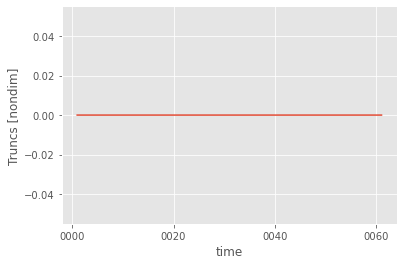

In [23]:
%matplotlib inline
stats.Truncs.plot();

### Maximum finite-volume CFL

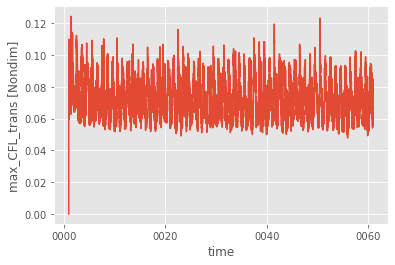

In [24]:
stats.max_CFL_trans.plot();

### Maximum finite-difference CFL

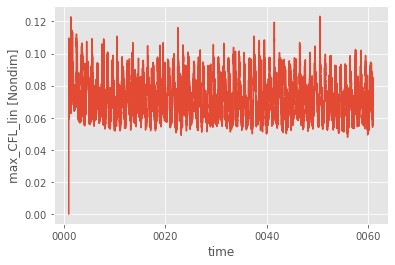

In [25]:
stats.max_CFL_lin.plot();

### Maximum CFL

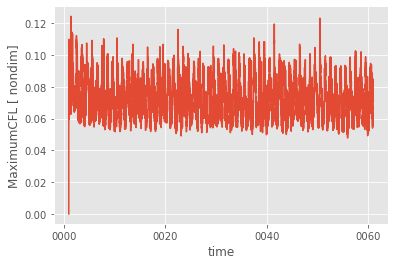

In [26]:
stats.MaximumCFL.plot();

### Energy/Mass

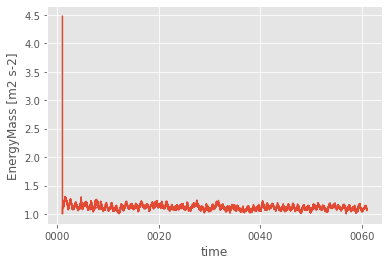

In [27]:
stats.EnergyMass.plot()

### Mean Sea Level

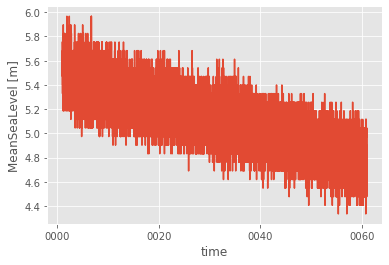

In [28]:
stats.MeanSeaLevel.plot(); 

### Total Mass

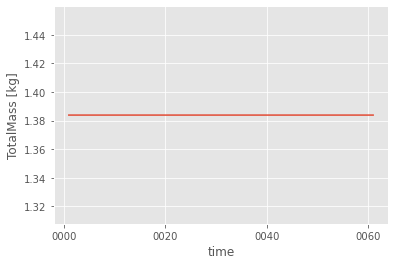

In [29]:
stats.TotalMass.plot(); 

### Mean Salinity

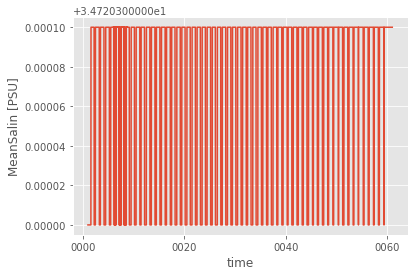

In [30]:
stats.MeanSalin.plot(); 

### Mean Temperature

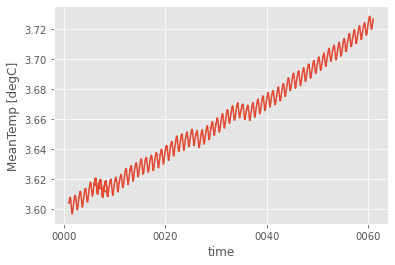

In [31]:
stats.MeanTemp.plot(); 

### Total Energy

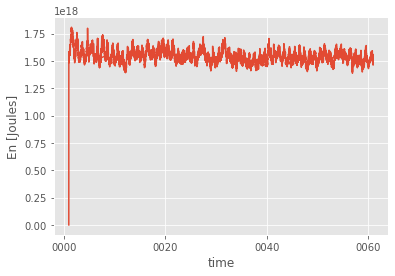

In [32]:
stats.En.plot(); 

### Available Potential Energy

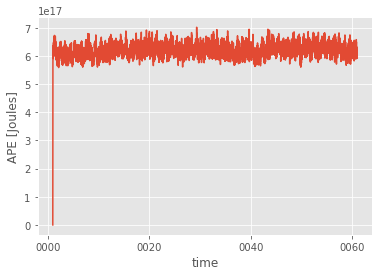

In [33]:
stats.APE.sum(axis=1,keep_attrs=True).plot(); 

### Total Salt

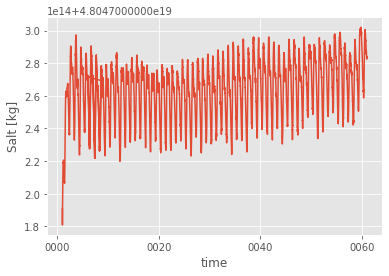

In [34]:
stats.Salt.plot(); 

### Total Salt Change between Entries

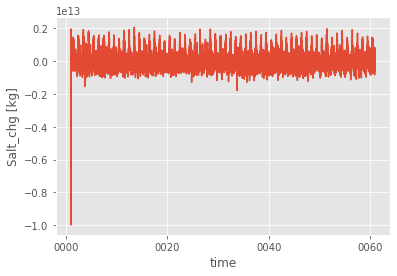

In [35]:
stats.Salt_chg.plot(); 

### Anomalous Total Salt Change

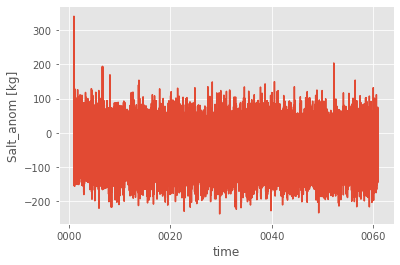

In [36]:
stats.Salt_anom.plot(); 

### Total Heat

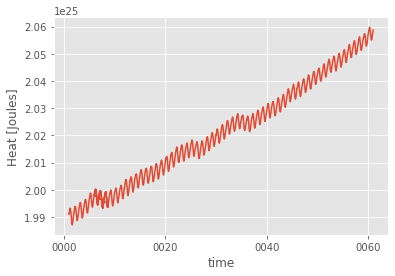

In [37]:
stats.Heat.plot(); 

### Total Heat Change between Entries

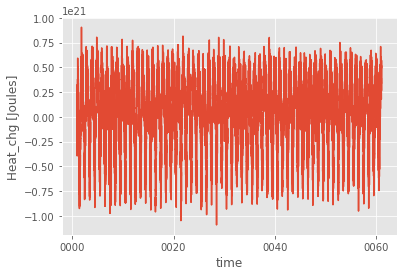

In [38]:
stats.Heat_chg.plot(); 

### Anomalous Total Heat Change

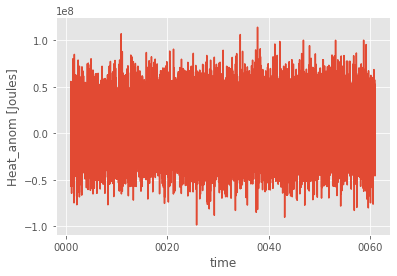

In [39]:
stats.Heat_anom.plot(); 

### Age

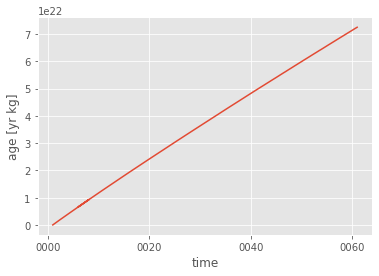

In [40]:
stats.age.plot(); 